<a href="https://colab.research.google.com/github/feranzie/Booking-flight-api/blob/main/triage_application_with_machine_learning_models_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV                                         # to split the data
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, r2_score, accuracy_score, confusion_matrix, classification_report, fbeta_score     # to evaluate our model
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

import warnings
import missingno as msno
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

pd.pandas.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 1.  Data Acquisition

#### Purpose:
To identify emergency department triage accuracy using the Korean Triage and Acuity Scale (KTAS) and evaluate the causes of mistriage.
#### Variables:
- <b>Group:</b>
- <b>Sex:</b> Sex of the patient
- <b>Age:</b> Age of the patient
- <b>Patients number per hour:</b>
- <b>Arrival mode:</b> Type of transportation to the hospital
- <b>Injury:</b> Whether the patient is injured or not
- <b>Chief_complain:</b> The patient's complaint
- <b>Mental:</b> The mental state of the patient
- <b>Pain:</b> Whether the patient has pain
- <b>NRS_pain:</b> Nurse's assessment of pain for the patient
- <b>SBP:</b> Systolic Blood Pressure.
- <b>DBP:</b> Diastolic Blood Pressure.
- <b>HR:</b> Heat Rate.
- <b>RR:</b> Respiratory rate
- <b>BT:</b> Body Temperature
- <b>Saturation:</b>
- <b>KTAS_RN:</b>
- <b>Diagnosis in ED:</b>
- <b>Disposition:</b> Action to be taken
- <b>KTAS_expert:</b>
- <b>Error_group:</b>
- <b>Length of stay_min:</b>
- <b>KTAS duration_min:</b>
- <b>mistriage:</b>





 It was seen in this document that some numerical data were actually categorical. These values are as follows.

- Reason Visit : Injury [1 = No, 2= Yes]
- Gender : Sex [1 = Famale, 2 = Male]
- Pain : Pain [1 = Yes, 0 = No]
- Menatal : Mental [1 = Alert, 2 = Verbol Response, 3 = Pain Response, 4 = Unresponse]
- Type of ED : Group [1 = Local ED 3th Degree, 2 = Regional ED 4tg Degree]
- Mode of Arrival : Arrival Mode [1 = Walking, 2 = Public Ambulance, 3 = Private Vehicle, 4 = Private Ambulance, 5,6,7 = Other]
- Disposition : Disposition [1 = Dischange, 2 = Admission to ward, 3 = Admission to ICU, 4 = Disharge, 5 = Transfer, 6 = Death, 7 = Surgery]
- KTAS : KTAS... [1,2,3 = Emergency, 4,5 = Non-Emergency]

## 2. Exploration Data Analysis (EDA)

In [3]:
# Reading the dataset
df = pd.read_csv("/content/data.csv", sep=';', encoding='ISO-8859-1')

In [4]:
# The first 5 observation units of the data set were accessed.
df.head(155)

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage
0,2,2,71,3,3,2,right ocular pain,1,1,2,160,100,84,18,36.6,100,2,Corneal abrasion,1,4,2,86,"5,00",1
1,1,1,56,12,3,2,right forearm burn,1,1,2,137,75,60,20,36.5,NaN,4,"Burn of hand, firts degree dorsum",1,5,4,64,"3,95",1
2,2,1,68,8,2,2,"arm pain, Lt",1,1,2,130,80,102,20,36.6,98,4,"Fracture of surgical neck of humerus, closed",2,5,4,862,"1,00",1
3,1,2,71,8,1,1,ascites tapping,1,1,3,139,94,88,20,36.5,NaN,4,Alcoholic liver cirrhosis with ascites,1,5,6,108,"9,83",1
4,1,2,58,4,3,1,"distension, abd",1,1,3,91,67,93,18,36.5,NaN,4,Ascites,1,5,8,109,"6,60",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,1,2,77,4,3,1,mental change,3,0,#BOÞ!,??,??,??,??,??,NaN,2,End stage kidney disease on dialysis,2,1,4,323,"13,90",2
151,2,2,49,7,4,1,dyspnea,2,0,#BOÞ!,110,70,65,20,36.3,97,3,"Hydrocephalus, unspecified",2,2,5,9697,"2,00",2
152,2,2,63,9,4,1,mental change,3,0,#BOÞ!,110,70,140,24,36.2,92,3,"Encephalopathy, unspecified",5,2,5,8188,"4,00",2
153,2,2,65,7,2,2,mental change,3,0,#BOÞ!,70,??,100,20,36.0,94,2,Traumatic subdural hemorrhage without open int...,5,1,5,150,"2,00",2


In [5]:
  #Feature information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Group                     1267 non-null   int64 
 1   Sex                       1267 non-null   int64 
 2   Age                       1267 non-null   int64 
 3   Patients number per hour  1267 non-null   int64 
 4   Arrival mode              1267 non-null   int64 
 5   Injury                    1267 non-null   int64 
 6   Chief_complain            1267 non-null   object
 7   Mental                    1267 non-null   int64 
 8   Pain                      1267 non-null   int64 
 9   NRS_pain                  1267 non-null   object
 10  SBP                       1267 non-null   object
 11  DBP                       1267 non-null   object
 12  HR                        1267 non-null   object
 13  RR                        1267 non-null   object
 14  BT                      

In [6]:
# The size of the data set
df.shape

(1267, 24)

In [7]:
# Descriptive statistics of the data set accessed.
df.describe([0.10,0.25,0.50,0.75,0.90,0.95,0.99]).T

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
Group,1267.000,1.457,0.498,1.000,1.000,1.000,1.000,2.000,2.000,2.000,2.000,2.000
Sex,1267.000,1.522,0.500,1.000,1.000,1.000,2.000,2.000,2.000,2.000,2.000,2.000
Age,1267.000,54.424,19.725,16.000,25.000,37.000,57.000,71.000,79.000,82.000,88.000,96.000
Patients number per hour,1267.000,7.519,3.161,1.000,3.000,5.000,7.000,10.000,12.000,13.000,15.000,17.000
Arrival mode,1267.000,2.821,0.808,1.000,2.000,2.000,3.000,3.000,4.000,4.000,5.000,7.000
Injury,1267.000,1.193,0.394,1.000,1.000,1.000,1.000,1.000,2.000,2.000,2.000,2.000
Mental,1267.000,1.106,0.448,1.000,1.000,1.000,1.000,1.000,1.000,2.000,3.340,4.000
Pain,1267.000,0.564,0.496,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000
KTAS_RN,1267.000,3.335,0.885,1.000,2.000,3.000,3.000,4.000,4.000,5.000,5.000,5.000
Disposition,1267.000,1.609,1.158,1.000,1.000,1.000,1.000,2.000,2.000,4.000,7.000,7.000


In [8]:
# Are there any null values?
df.isnull().values.any()

True

# 3. DATA PREPROCESSING
# 3.1. Missing Value Analysis

In [9]:
def missing_values_table(dataframe):
    variables_with_na = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[variables_with_na].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[variables_with_na].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df)
    return variables_with_na

df['NRS_pain'] = df[["NRS_pain"]].replace("#BO�!",np.NaN)

missing_values_table(df)

                 n_miss  ratio
Saturation          688 54.300
Diagnosis in ED       2  0.160


['Saturation', 'Diagnosis in ED']

<Axes: >

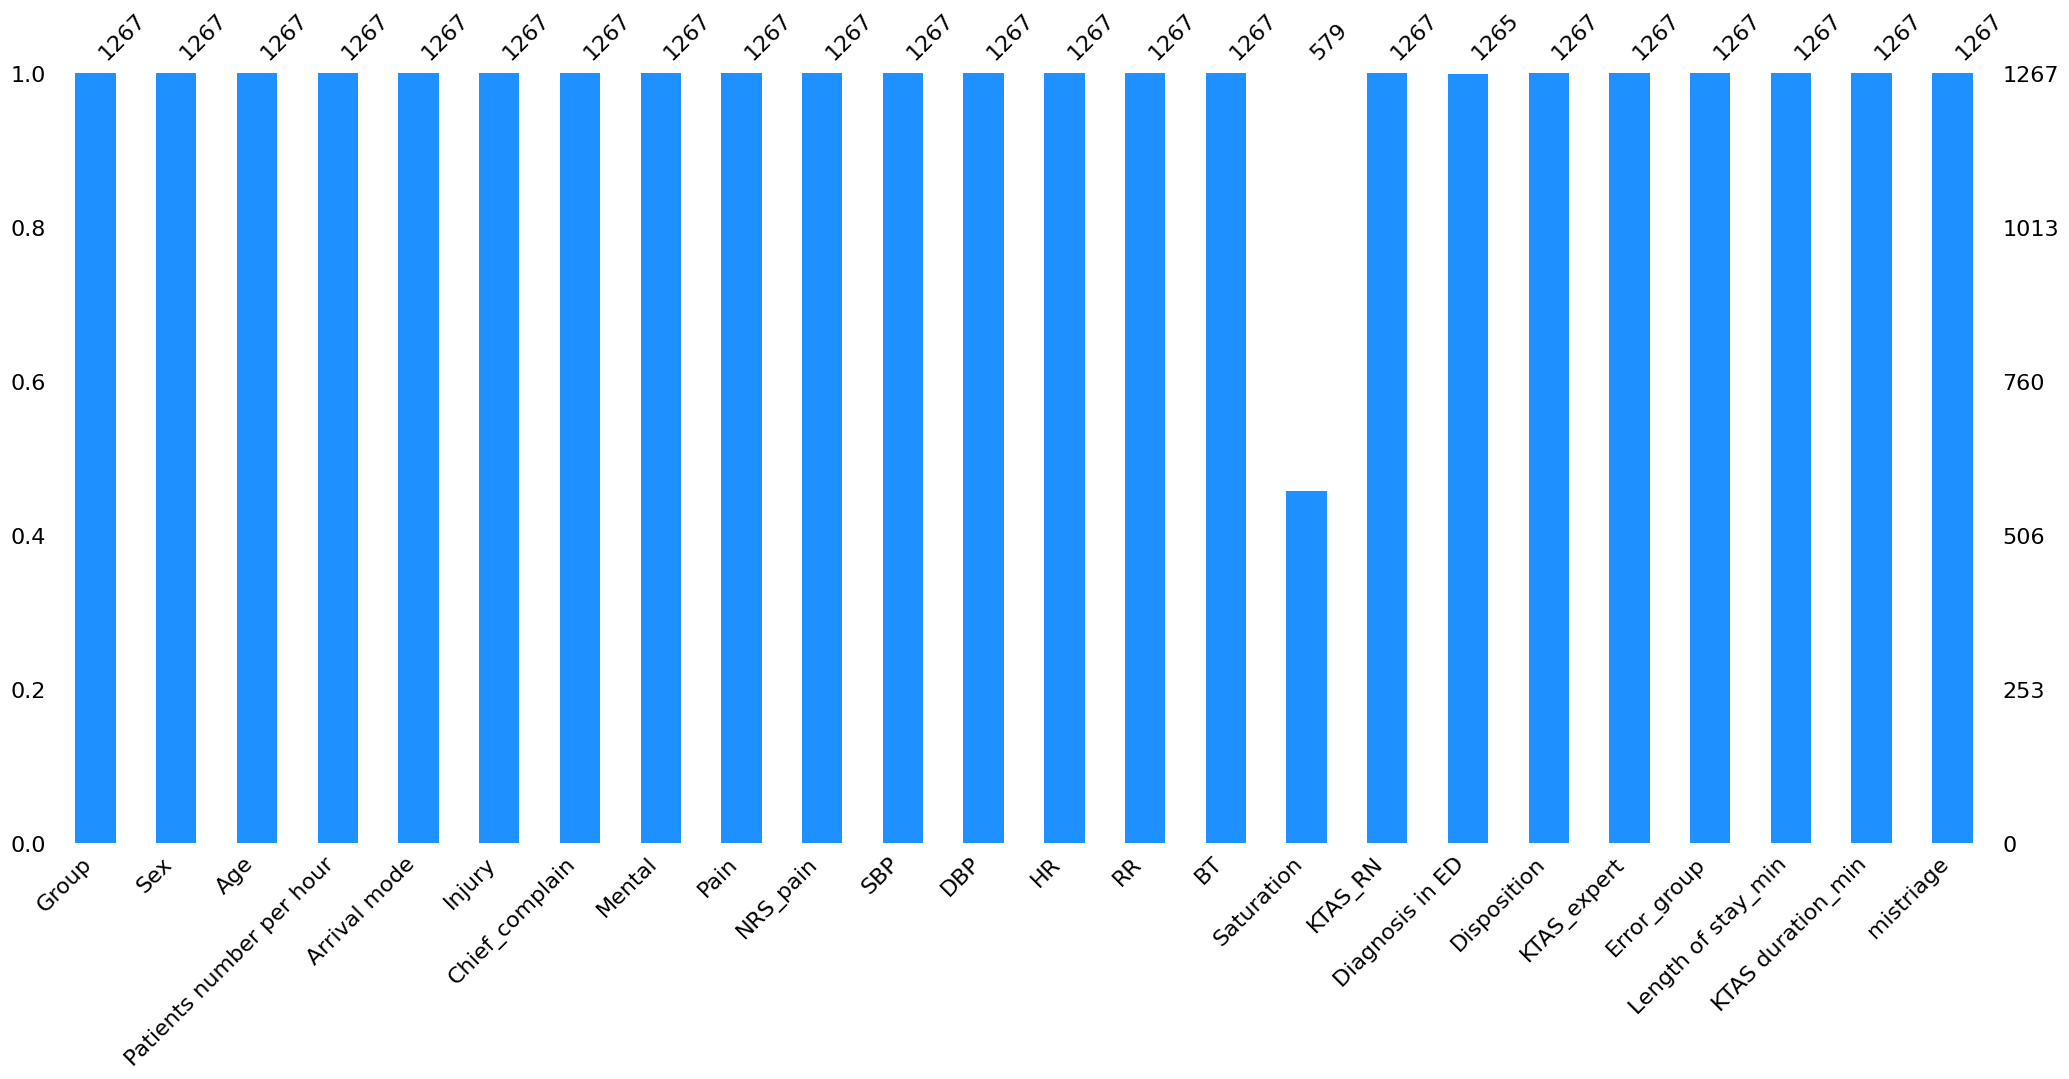

In [9]:
msno.bar(df, color="dodgerblue")

In [10]:
# Fill Missing Value

df["NRS_pain"] = df.groupby(["mistriage", "KTAS_expert"])["NRS_pain"].transform(lambda x: x.fillna(x.mode()[0]))
df["Saturation"] = df.groupby(["mistriage", "KTAS_expert"])["Saturation"].transform(lambda x: x.fillna(x.mode()[0]))
df["Diagnosis in ED"] = df.groupby(["mistriage", "KTAS_expert"])["Diagnosis in ED"].transform(lambda x: x.fillna(x.mode()[0]))

In [11]:
df.isnull().values.any()

False

<Axes: >

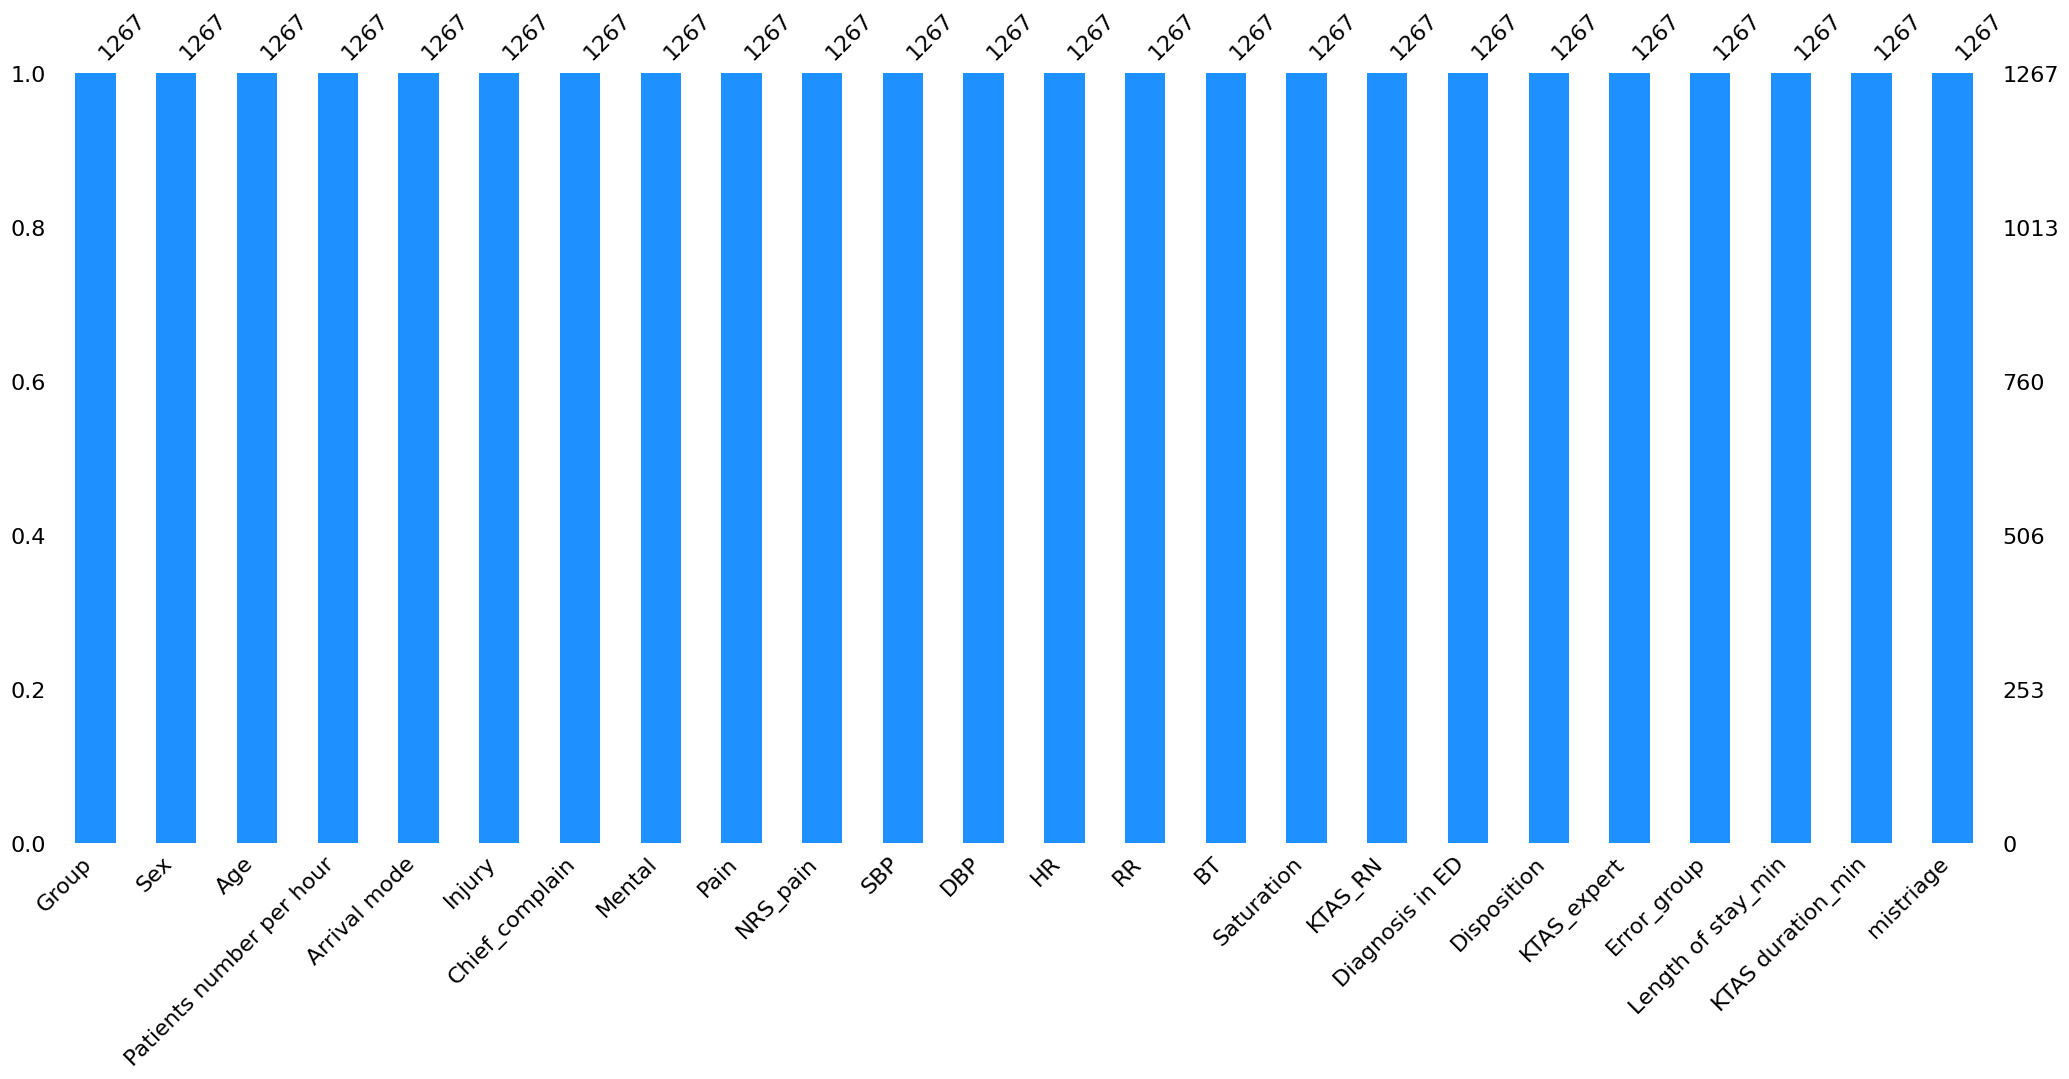

In [12]:
msno.bar(df, color="dodgerblue")

## 3.2. Feature Engineering

In [12]:
injury_cat = ['No','Yes']
sex_cat = ['Female','Male']
pain_cat = ['No','Yes']
mental_cat = ['Alert','Verbose Response','Pain Response','Unresponsive']
group_cat = ['Local ED (3th Degree)', 'Regional ED (4th Degree)']
arrival_mode_cat = ['Walking','Public Ambulance', 'Private Vehicle','Private Ambulance', 'Other','Other','Other']
disposition_cat = ['Discharge', 'Admission to Ward', 'Admission to ICU', 'Discharge', 'Transfer', 'Death', 'Surgery']
KTAS_cat = ['Emergency','Emergency','Emergency', 'Non-Emergency', 'Non-Emergency']
mistriage_cat = ['Normal Triage','Over Triage','Under Triage']

# df['KTAS duration_min'] = df['KTAS duration_min'].apply(lambda x: int(float(x.replace(',', '.'))))
df['KTAS duration_min'] = pd.to_numeric(df['KTAS duration_min'].astype(str).str.replace(',', '.'), errors='coerce').fillna(0).astype(int)

# df['NRS_pain'] = df['NRS_pain'].apply(lambda x:int(x))
df['NRS_pain'] = pd.to_numeric(df['NRS_pain'], errors='coerce').fillna(0).astype(int)  # Replace NaN with 0 if desired


###############################################################################################################################
#Categorical data were entered as numerical data. Therefore, it was categorized again categorically to make it more meaningful.
###############################################################################################################################
df.loc[df["Sex"] == 1, "Sex"] = sex_cat[0]
df.loc[df["Sex"] == 2, "Sex"] = sex_cat[1]

df.loc[df["Injury"] == 1, "Injury"] = injury_cat[0]
df.loc[df["Injury"] == 2, "Injury"] = injury_cat[1]

df.loc[df["Pain"] == 0, "Pain"] = pain_cat[0]
df.loc[df["Pain"] == 1, "Pain"] = pain_cat[1]

df.loc[df["Mental"] == 1, "Mental"] = mental_cat[0]
df.loc[df["Mental"] == 2, "Mental"] = mental_cat[1]
df.loc[df["Mental"] == 3, "Mental"] = mental_cat[2]
df.loc[df["Mental"] == 4, "Mental"] = mental_cat[3]

df.loc[df["Group"] == 1, "Group"] = group_cat[0]
df.loc[df["Group"] == 2, "Group"] = group_cat[1]

df.loc[df["Arrival mode"] == 1, "Arrival mode"] = arrival_mode_cat[0]
df.loc[df["Arrival mode"] == 2, "Arrival mode"] = arrival_mode_cat[1]
df.loc[df["Arrival mode"] == 3, "Arrival mode"] = arrival_mode_cat[2]
df.loc[df["Arrival mode"] == 4, "Arrival mode"] = arrival_mode_cat[3]
df.loc[df["Arrival mode"] == 5, "Arrival mode"] = arrival_mode_cat[4]
df.loc[df["Arrival mode"] == 6, "Arrival mode"] = arrival_mode_cat[5]
df.loc[df["Arrival mode"] == 7, "Arrival mode"] = arrival_mode_cat[6]

df.loc[df["Disposition"] == 1, "Disposition"] = disposition_cat[0]
df.loc[df["Disposition"] == 2, "Disposition"] = disposition_cat[1]
df.loc[df["Disposition"] == 3, "Disposition"] = disposition_cat[2]
df.loc[df["Disposition"] == 4, "Disposition"] = disposition_cat[3]
df.loc[df["Disposition"] == 5, "Disposition"] = disposition_cat[4]
df.loc[df["Disposition"] == 6, "Disposition"] = disposition_cat[5]
df.loc[df["Disposition"] == 7, "Disposition"] = disposition_cat[6]

df.loc[df["KTAS_RN"] == 1, "KTAS_RN"] = KTAS_cat[0]
df.loc[df["KTAS_RN"] == 2, "KTAS_RN"] = KTAS_cat[1]
df.loc[df["KTAS_RN"] == 3, "KTAS_RN"] = KTAS_cat[2]
df.loc[df["KTAS_RN"] == 4, "KTAS_RN"] = KTAS_cat[3]
df.loc[df["KTAS_RN"] == 5, "KTAS_RN"] = KTAS_cat[4]

# df.loc[df["KTAS_expert"] == 1, "KTAS_expert"] = KTAS_cat[0]
# df.loc[df["KTAS_expert"] == 2, "KTAS_expert"] = KTAS_cat[1]
# df.loc[df["KTAS_expert"] == 3, "KTAS_expert"] = KTAS_cat[2]
# df.loc[df["KTAS_expert"] == 4, "KTAS_expert"] = KTAS_cat[3]
# df.loc[df["KTAS_expert"] == 5, "KTAS_expert"] = KTAS_cat[4]

df.loc[df["mistriage"] == 0, "mistriage"] = mistriage_cat[0]
df.loc[df["mistriage"] == 1, "mistriage"] = mistriage_cat[1]
df.loc[df["mistriage"] == 2, "mistriage"] = mistriage_cat[2]
###############################################################################################################################
##############               Nonsense data was encountered in variables containing numerical data.                 ############
##############                 These values have been replaced by the mode of the variable.                        ############
###############################################################################################################################

df[["SBP","DBP","HR","RR","BT","Saturation"]] = df[["SBP","DBP","HR","RR","BT","Saturation"]].replace("??",0).astype(str).astype(float)
df['SBP'] = df['SBP'].replace(0,df['SBP'].mode()[0])
df['DBP'] = df['DBP'].replace(0,df['DBP'].mode()[0])

###############################################################################################################################
##############                                        Feature Engineering                                          ############
###############################################################################################################################
interval = (0, 25, 45, 60, 100)
cats = ['Young', 'Adult', 'Mid_Age', 'Old']
df["New_Age"] = pd.cut(df.Age, interval, labels=cats)

df.loc[df['SBP'] < 80, 'New_SBP'] = 'Low'
df.loc[(df["SBP"] >= 80) & (df["SBP"] <= 120), 'New_SBP'] = 'Normal'
df.loc[df['SBP'] > 120, 'New_SBP'] = 'High'

df.loc[df['DBP'] < 60, 'New_DBP'] = 'Low'
df.loc[(df["DBP"] >= 60) & (df["DBP"] <= 80), 'New_DBP'] = 'Normal'
df.loc[df['DBP'] > 80, 'New_DBP'] = 'High'

df.loc[df['HR'] < 45, 'New_HR'] = 'Low'
df.loc[(df["HR"] >= 45) & (df["HR"] <= 100), 'New_HR'] = 'Normal'
df.loc[df['HR'] > 100, 'New_HR'] = 'High'

df.loc[df['RR'] < 12, 'New_RR'] = 'Low'
df.loc[(df["RR"] >= 12) & (df["RR"] <= 25), 'New_RR'] = 'Normal'
df.loc[df['RR'] > 25, 'New_RR'] = 'High'

df.loc[df['BT'] < 36.4, 'New_BT'] = 'Low'
df.loc[(df["BT"] >= 36.4) & (df["BT"] <= 37.6), 'New_BT'] = 'Normal'
df.loc[df['BT'] > 37.6, 'New_BT'] = 'High'

df.loc[df['NRS_pain'] < 3, 'New_NRS_pain'] = 'Low Pain'
df.loc[(df["NRS_pain"] >= 3) & (df["NRS_pain"] <= 7), 'New_NRS_pain'] = 'Pain'
df.loc[df['NRS_pain'] > 7, 'New_NRS_pain'] = 'High Pain'

df.loc[df['KTAS duration_min'] < 10, 'New_KTAS_duration_min'] = 'Immediate'
df.loc[(df["KTAS duration_min"] >= 10) & (df["KTAS duration_min"] <= 60), 'New_KTAS_duration_min'] = 'Very Urgent'
df.loc[(df["KTAS duration_min"] >= 61) & (df["KTAS duration_min"] <= 120), 'New_KTAS_duration_min'] = 'Urgent'
df.loc[(df["KTAS duration_min"] >= 121) & (df["KTAS duration_min"] <= 240), 'New_KTAS_duration_min'] = 'Standart'
df.loc[df['KTAS duration_min'] > 240, 'New_KTAS_duration_min'] = 'Non-Urgent'

df.loc[df['Length of stay_min'] < 10, 'New_Length_of_stay_min'] = 'Immediate'
df.loc[(df["Length of stay_min"] >= 10) & (df["Length of stay_min"] <= 60), 'New_Length_of_stay_min'] = 'Very Urgent'
df.loc[(df["Length of stay_min"] >= 61) & (df["Length of stay_min"] <= 120), 'New_Length_of_stay_min'] = 'Urgent'
df.loc[(df["Length of stay_min"] >= 121) & (df["Length of stay_min"] <= 240), 'New_Length_of_stay_min'] = 'Standart'
df.loc[df['Length of stay_min'] > 240, 'New_Length_of_stay_min'] = 'Non-Urgent'

df.head()

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage,New_Age,New_SBP,New_DBP,New_HR,New_RR,New_BT,New_NRS_pain,New_KTAS_duration_min,New_Length_of_stay_min
0,Regional ED (4th Degree),Male,71,3,Private Vehicle,Yes,right ocular pain,Alert,Yes,2,160.000,100.000,84.000,18.000,36.600,100.000,Emergency,Corneal abrasion,Discharge,4,2,86,5,Over Triage,Old,High,High,Normal,Normal,Normal,Low Pain,Immediate,Urgent
1,Local ED (3th Degree),Female,56,12,Private Vehicle,Yes,right forearm burn,Alert,Yes,2,137.000,75.000,60.000,20.000,36.500,98.000,Non-Emergency,"Burn of hand, firts degree dorsum",Discharge,5,4,64,3,Over Triage,Mid_Age,High,Normal,Normal,Normal,Normal,Low Pain,Immediate,Urgent
2,Regional ED (4th Degree),Female,68,8,Public Ambulance,Yes,"arm pain, Lt",Alert,Yes,2,130.000,80.000,102.000,20.000,36.600,98.000,Non-Emergency,"Fracture of surgical neck of humerus, closed",Admission to Ward,5,4,862,1,Over Triage,Old,High,Normal,High,Normal,Normal,Low Pain,Immediate,Non-Urgent
3,Local ED (3th Degree),Male,71,8,Walking,No,ascites tapping,Alert,Yes,3,139.000,94.000,88.000,20.000,36.500,98.000,Non-Emergency,Alcoholic liver cirrhosis with ascites,Discharge,5,6,108,9,Over Triage,Old,High,High,Normal,Normal,Normal,Pain,Immediate,Urgent
4,Local ED (3th Degree),Male,58,4,Private Vehicle,No,"distension, abd",Alert,Yes,3,91.000,67.000,93.000,18.000,36.500,98.000,Non-Emergency,Ascites,Discharge,5,8,109,6,Over Triage,Mid_Age,Normal,Normal,Normal,Normal,Normal,Pain,Immediate,Urgent


## 3.3. Outlier Anaysis

In [13]:
##################################################################################################################
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.05)
    quartile3 = dataframe[variable].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
##################################################################################################################
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
##################################################################################################################
def has_outliers(dataframe, num_col_names, plot=False):
    variable_names = []
    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        if dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].any(axis=None):
            number_of_outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].shape[0]
            print(col, ":", number_of_outliers)
            variable_names.append(col)
            if plot:
                sns.boxplot(x=dataframe[col])
                plt.show()
    return variable_names

In [14]:
# has_outliers(df, ["Length of stay_min","Saturation","SBP","DBP","HR","RR","BT"])

# Ensure the columns are numeric
numeric_columns = ["Length of stay_min", "Saturation", "SBP", "DBP", "HR", "RR", "BT"]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[numeric_columns] = df[numeric_columns].fillna(0)  # Replace NaN with 0, or another value
def has_outliers(df, columns):
    for col in columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            outliers = ((df[col] < (q1 - 1.5 * iqr)) | (df[col] > (q3 + 1.5 * iqr))).any()
            print(f"{col} has outliers: {outliers}")
        else:
            print(f"Skipping non-numeric column: {col}")


# Now apply the `has_outliers` function
has_outliers(df, numeric_columns)


Length of stay_min has outliers: True
Saturation has outliers: True
SBP has outliers: True
DBP has outliers: True
HR has outliers: True
RR has outliers: True
BT has outliers: True


In [15]:
outlier_column = ["Length of stay_min","Saturation","RR","BT"]
for i in outlier_column:
    replace_with_thresholds(df,i)

## 4. DATA VISUALIZATION

<Axes: xlabel='KTAS duration_min', ylabel='Density'>

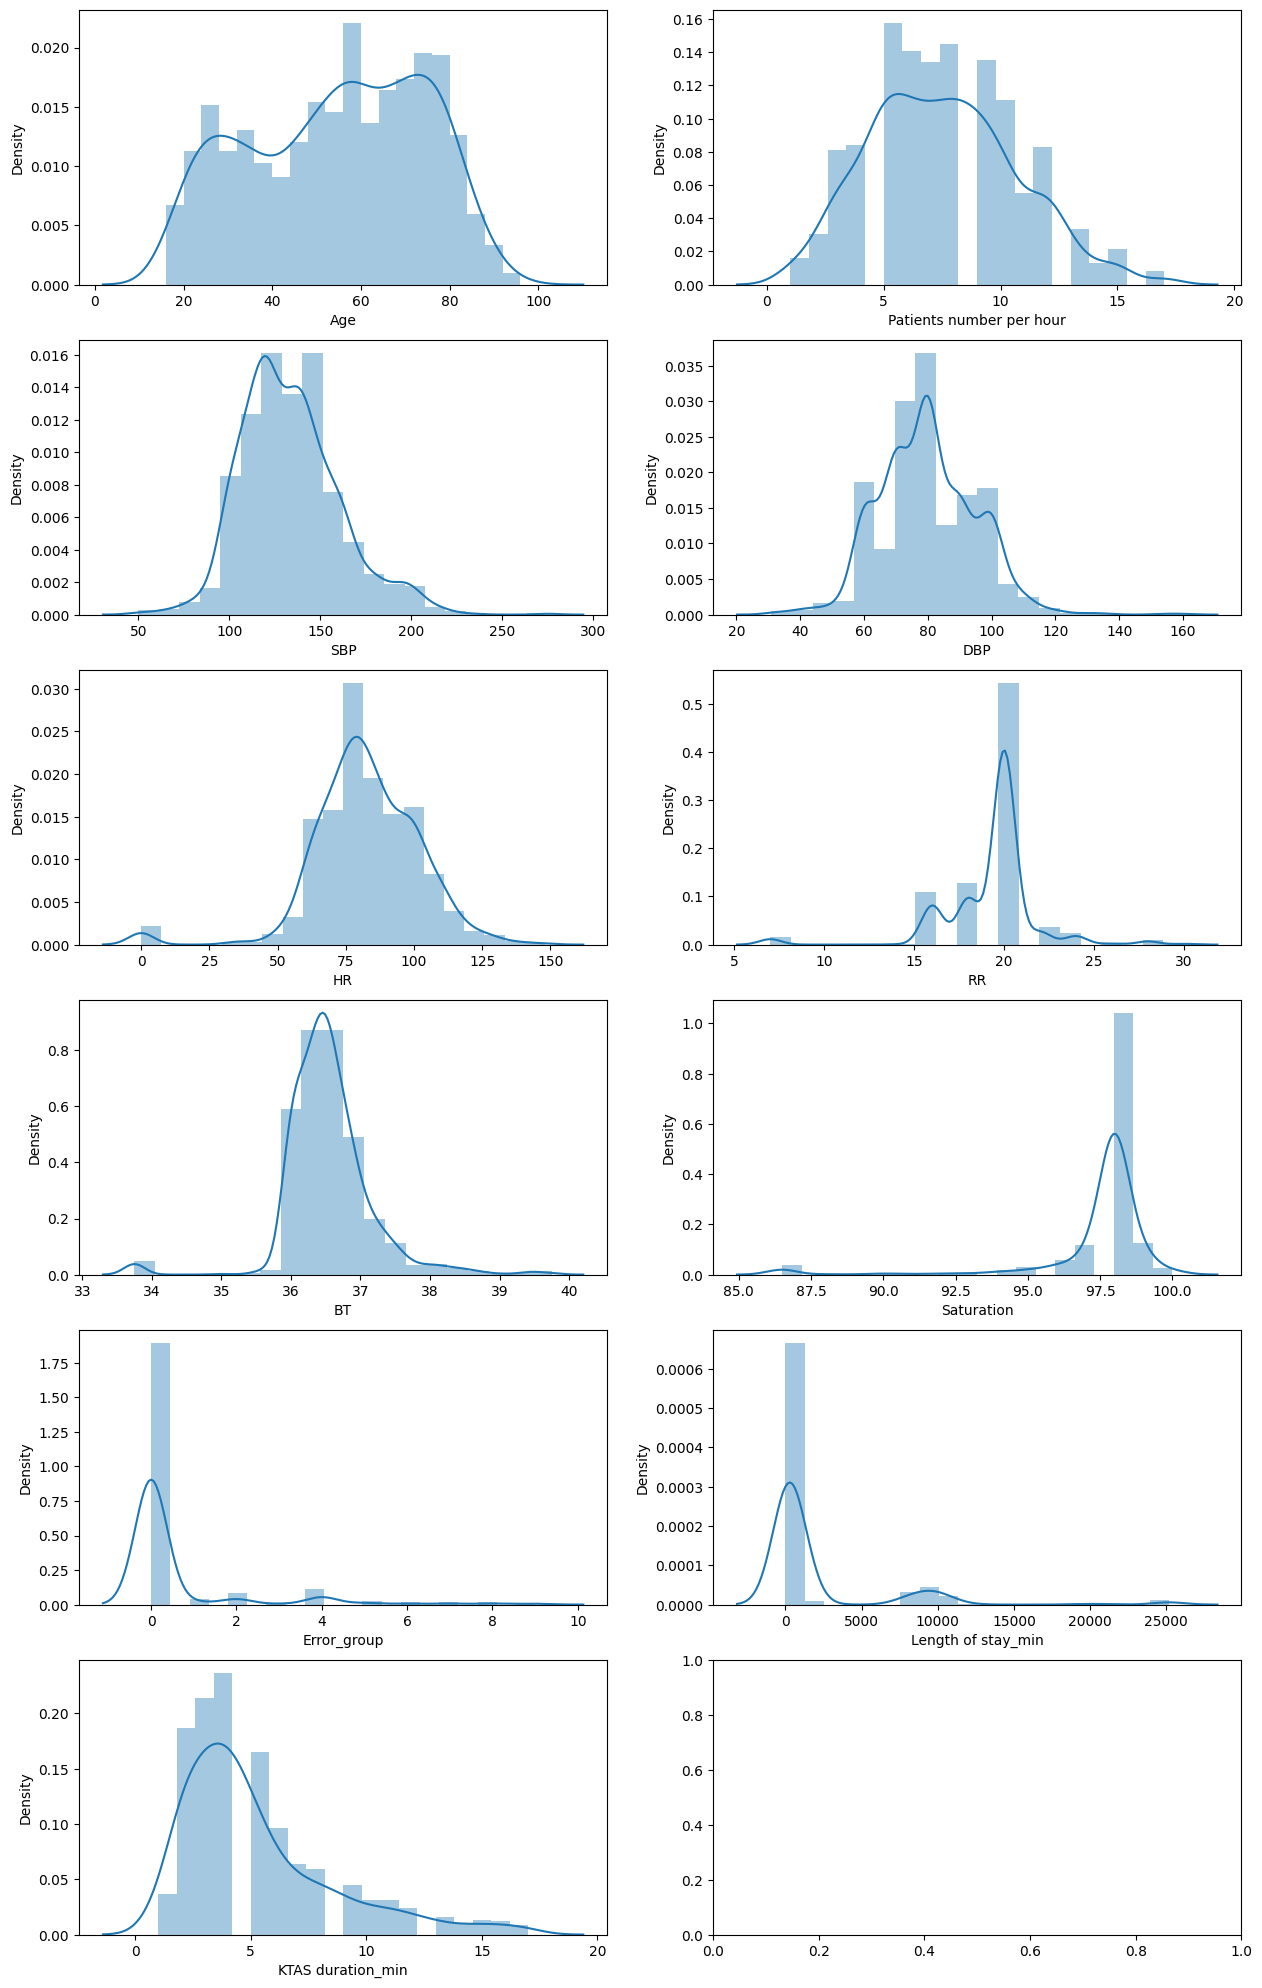

In [ ]:
# Histogram and density graphs of all variables were accessed.
fig, ax = plt.subplots(6,2, figsize=(15,25))
sns.distplot(df['Age'], bins = 20, ax=ax[0,0])
sns.distplot(df['Patients number per hour'], bins = 20, ax=ax[0,1])
sns.distplot(df['SBP'], bins = 20, ax=ax[1,0])
sns.distplot(df['DBP'], bins = 20, ax=ax[1,1])
sns.distplot(df['HR'], bins = 20, ax=ax[2,0])
sns.distplot(df['RR'], bins = 20, ax=ax[2,1])
sns.distplot(df['BT'], bins = 20, ax=ax[3,0])
sns.distplot(df['Saturation'], bins = 20, ax=ax[3,1])
sns.distplot(df['Error_group'], bins = 20, ax=ax[4,0])
sns.distplot(df['Length of stay_min'], bins = 20, ax=ax[4,1])
sns.distplot(df['KTAS duration_min'], bins = 20, ax=ax[5,0])

# 5. Data Segmentetion with Machine Learning Models
### 5.1. One Hot Encoding and Robust Scaler

In [16]:
def one_hot_encoder(dataframe, categorical_columns, nan_as_category=False):
    original_columns = list(dataframe.columns)
    dataframe = pd.get_dummies(dataframe, columns=categorical_columns,
                               dummy_na=nan_as_category, drop_first=True)
    new_columns = [col for col in dataframe.columns if col not in original_columns]
    return dataframe, new_columns

def robust_scaler(variable):
    var_median = variable.median()
    quartile1 = variable.quantile(0.05)
    quartile3 = variable.quantile(0.95)
    interquantile_range = quartile3 - quartile1
    if int(interquantile_range) == 0:
        quartile1 = variable.quantile(0.05)
        quartile3 = variable.quantile(0.95)
        interquantile_range = quartile3 - quartile1
        z = (variable - var_median) / interquantile_range
        return round(z, 3)
    else:
        z = (variable - var_median) / interquantile_range
    return round(z, 3)

In [17]:
new_df = df[["Group", "Sex", "Patients number per hour", "Arrival mode", "Injury", "Mental", "Pain", "Saturation", "KTAS_RN",
"Disposition", "KTAS_expert", "Length of stay_min", "mistriage", "New_Age", "New_SBP", "New_DBP", "New_HR",
"New_RR", "New_BT", "New_NRS_pain", "New_KTAS_duration_min", "New_Length_of_stay_min"]]
new_df.head()

,Group,Sex,Patients number per hour,Arrival mode,Injury,Mental,Pain,Saturation,KTAS_RN,Disposition,KTAS_expert,Length of stay_min,mistriage,New_Age,New_SBP,New_DBP,New_HR,New_RR,New_BT,New_NRS_pain,New_KTAS_duration_min,New_Length_of_stay_min
0,Regional ED (4th Degree),Male,3,Private Vehicle,Yes,Alert,Yes,100.000,Emergency,Discharge,4,86.000,Over Triage,Old,High,High,Normal,Normal,Normal,Low Pain,Immediate,Urgent
1,Local ED (3th Degree),Female,12,Private Vehicle,Yes,Alert,Yes,98.000,Non-Emergency,Discharge,5,64.000,Over Triage,Mid_Age,High,Normal,Normal,Normal,Normal,Low Pain,Immediate,Urgent
2,Regional ED (4th Degree),Female,8,Public Ambulance,Yes,Alert,Yes,98.000,Non-Emergency,Admission to Ward,5,862.000,Over Triage,Old,High,Normal,High,Normal,Normal,Low Pain,Immediate,Non-Urgent
3,Local ED (3th Degree),Male,8,Walking,No,Alert,Yes,98.000,Non-Emergency,Discharge,5,108.000,Over Triage,Old,High,High,Normal,Normal,Normal,Pain,Immediate,Urgent
4,Local ED (3th Degree),Male,4,Private Vehicle,No,Alert,Yes,98.000,Non-Emergency,Discharge,5,109.000,Over Triage,Mid_Age,Normal,Normal,Normal,Normal,Normal,Pain,Immediate,Urgent


In [18]:
dff=new_df.copy()

In [19]:
new_df.drop(['KTAS_expert'], axis=1, inplace=True)

In [20]:
like_num = [col for col in new_df.columns if new_df[col].dtypes != 'O' and len(new_df[col].value_counts()) > 10]
cols_need_scale = [col for col in new_df.columns if col not in like_num
                   and col not in 'mistriage']

In [21]:
for col in like_num:
    new_df[col] = robust_scaler(new_df[col])

new_df, one_hot_encodeds = one_hot_encoder(new_df, cols_need_scale)

Data Splitting

In [22]:
new_df.head()

,Patients number per hour,Saturation,Length of stay_min,mistriage,Group_Regional ED (4th Degree),Sex_Male,Arrival mode_Private Ambulance,Arrival mode_Private Vehicle,Arrival mode_Public Ambulance,Arrival mode_Walking,Injury_Yes,Mental_Pain Response,Mental_Unresponsive,Mental_Verbose Response,Pain_Yes,KTAS_RN_Non-Emergency,Disposition_Admission to Ward,Disposition_Death,Disposition_Discharge,Disposition_Surgery,Disposition_Transfer,New_Age_Adult,New_Age_Mid_Age,New_Age_Old,New_SBP_Low,New_SBP_Normal,New_DBP_Low,New_DBP_Normal,New_HR_Low,New_HR_Normal,New_RR_Low,New_RR_Normal,New_BT_Low,New_BT_Normal,New_NRS_pain_Low Pain,New_NRS_pain_Pain,New_KTAS_duration_min_Very Urgent,New_Length_of_stay_min_Non-Urgent,New_Length_of_stay_min_Standart,New_Length_of_stay_min_Urgent,New_Length_of_stay_min_Very Urgent
0,-0.400,0.400,-0.019,Over Triage,True,True,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,True,True,False,False,False,False,True,False
1,0.500,0.000,-0.021,Over Triage,False,False,False,True,False,False,True,False,False,False,True,True,False,False,True,False,False,False,True,False,False,False,False,True,False,True,False,True,False,True,True,False,False,False,False,True,False
2,0.100,0.000,0.058,Over Triage,True,False,False,False,True,False,True,False,False,False,True,True,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,True,True,False,False,True,False,False,False
3,0.100,0.000,-0.017,Over Triage,False,True,False,False,False,True,False,False,False,False,True,True,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,True,False,True,False,False,False,True,False
4,-0.300,0.000,-0.016,Over Triage,False,True,False,True,False,False,False,False,False,False,True,True,False,False,True,False,False,False,True,False,False,True,False,True,False,True,False,True,False,True,False,True,False,False,False,True,False


In [38]:
dff.head()

,Group,Sex,Patients number per hour,Arrival mode,Injury,Mental,Pain,Saturation,KTAS_RN,Disposition,KTAS_expert,Length of stay_min,mistriage,New_Age,New_SBP,New_DBP,New_HR,New_RR,New_BT,New_NRS_pain,New_KTAS_duration_min,New_Length_of_stay_min
0,Regional ED (4th Degree),Male,3,Private Vehicle,Yes,Alert,Yes,100.000,Emergency,Discharge,4,86.000,Over Triage,Old,High,High,Normal,Normal,Normal,Low Pain,Immediate,Urgent
1,Local ED (3th Degree),Female,12,Private Vehicle,Yes,Alert,Yes,98.000,Non-Emergency,Discharge,5,64.000,Over Triage,Mid_Age,High,Normal,Normal,Normal,Normal,Low Pain,Immediate,Urgent
2,Regional ED (4th Degree),Female,8,Public Ambulance,Yes,Alert,Yes,98.000,Non-Emergency,Admission to Ward,5,862.000,Over Triage,Old,High,Normal,High,Normal,Normal,Low Pain,Immediate,Non-Urgent
3,Local ED (3th Degree),Male,8,Walking,No,Alert,Yes,98.000,Non-Emergency,Discharge,5,108.000,Over Triage,Old,High,High,Normal,Normal,Normal,Pain,Immediate,Urgent
4,Local ED (3th Degree),Male,4,Private Vehicle,No,Alert,Yes,98.000,Non-Emergency,Discharge,5,109.000,Over Triage,Mid_Age,Normal,Normal,Normal,Normal,Normal,Pain,Immediate,Urgent


In [23]:
X = new_df.drop('mistriage', axis=1)
y = np.ravel(dff[['KTAS_expert']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 357)

In [24]:
X_train.head()

,Patients number per hour,Saturation,Length of stay_min,Group_Regional ED (4th Degree),Sex_Male,Arrival mode_Private Ambulance,Arrival mode_Private Vehicle,Arrival mode_Public Ambulance,Arrival mode_Walking,Injury_Yes,Mental_Pain Response,Mental_Unresponsive,Mental_Verbose Response,Pain_Yes,KTAS_RN_Non-Emergency,Disposition_Admission to Ward,Disposition_Death,Disposition_Discharge,Disposition_Surgery,Disposition_Transfer,New_Age_Adult,New_Age_Mid_Age,New_Age_Old,New_SBP_Low,New_SBP_Normal,New_DBP_Low,New_DBP_Normal,New_HR_Low,New_HR_Normal,New_RR_Low,New_RR_Normal,New_BT_Low,New_BT_Normal,New_NRS_pain_Low Pain,New_NRS_pain_Pain,New_KTAS_duration_min_Very Urgent,New_Length_of_stay_min_Non-Urgent,New_Length_of_stay_min_Standart,New_Length_of_stay_min_Urgent,New_Length_of_stay_min_Very Urgent
428,-0.500,-0.600,0.966,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,False,False
772,-0.200,0.000,0.006,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,True,False,True,False,False,True,False,False,False
873,0.300,0.000,-0.020,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,True,False,True,False,True,True,False,False,False,False,True,False
572,0.200,0.000,-0.013,False,False,False,False,True,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,True,False,False,True,False,False
385,0.200,-0.400,0.968,True,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,False,False


In [25]:
# Let's set the parameters to find the best parameter to use in our models. These parameters will be chosen as the best to visit with GridSearchCV.

lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [200, 500, 1000],
               "max_depth": [3, 5, 8],
               "colsample_bytree": [1, 0.8, 0.5]}

lgbm = LGBMClassifier(random_state=357)

# Let's try the parameters one by one with the help of GridSearchCV and find the best parameter.
gs_cv_lgbm = GridSearchCV(lgbm, lgbm_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 35
[LightGBM] [Info] Start training from score -3.742618
[LightGBM] [Info] Start training from score -1.705736
[LightGBM] [Info] Start training from score -0.991082
[LightGBM] [Info] Start training from score -1.009875
[LightGBM] [Info] Start training from score -2.826327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

In [26]:

knn_tuned = KNeighborsClassifier().fit(X_train, y_train)
svm_tuned = SVC(random_state=357,gamma='auto').fit(X_train, y_train)

# Let's tune the models with the best parameters found.
lgbm_tuned = LGBMClassifier(**gs_cv_lgbm.best_params_, random_state=357).fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 35
[LightGBM] [Info] Start training from score -3.742618
[LightGBM] [Info] Start training from score -1.705736
[LightGBM] [Info] Start training from score -0.991082
[LightGBM] [Info] Start training from score -1.009875
[LightGBM] [Info] Start training from score -2.826327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [27]:
# Result
models = [("KNN", knn_tuned),
          ("SVM", svm_tuned),
          ("LGBM", lgbm_tuned),
         ]

for name, model in models:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    msg = "%s: (%f)" % (name, acc)
    print(msg)



KNN: (0.618110)
SVM: (0.732283)
LGBM: (0.716535)


In [28]:
# Result
models = [("KNN", knn_tuned),
          ("SVM", svm_tuned),
          ("LGBM", lgbm_tuned),
         ]

for name, model in models:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    msg = "%s: (%f)" % (name, acc)
    print(msg)

# Check the structure of features
print("Feature Data:")
print(X.head())  # Look at the first few rows
print(X.info())  # Verify data types and missing values

# Check the distribution of the target variable in y_test (convert to pandas series)
print("\nTarget Variable Distribution:")
print(pd.Series(y_test).value_counts())  # Distribution of the actual target variable

# Check the distribution of the predicted values (y_pred)
print("\nPredicted Values Distribution:")
print(pd.Series(y_pred).value_counts())  # Distribution of the predicted target variable


KNN: (0.618110)
SVM: (0.732283)
LGBM: (0.716535)
Feature Data:
   Patients number per hour  Saturation  Length of stay_min  \
0                    -0.400       0.400              -0.019   
1                     0.500       0.000              -0.021   
2                     0.100       0.000               0.058   
3                     0.100       0.000              -0.017   
4                    -0.300       0.000              -0.016   

   Group_Regional ED (4th Degree)  Sex_Male  Arrival mode_Private Ambulance  \
0                            True      True                           False   
1                           False     False                           False   
2                            True     False                           False   
3                           False      True                           False   
4                           False      True                           False   

   Arrival mode_Private Vehicle  Arrival mode_Public Ambulance  \
0                

In [29]:
# Check the best parameters selected by GridSearchCV
print("Best Parameters for LGBM:", gs_cv_lgbm.best_params_)


Best Parameters for LGBM: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}



Evaluating KNN model:
Accuracy: 0.6181
Precision: 0.6041
Recall: 0.6181
F1 Score: 0.6053


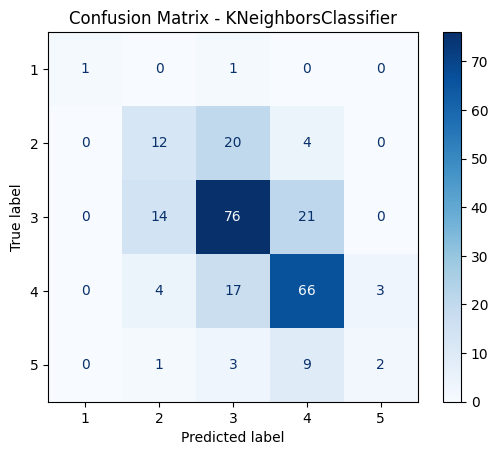


Evaluating SVM model:
Accuracy: 0.7323
Precision: 0.6769
Recall: 0.7323
F1 Score: 0.6859


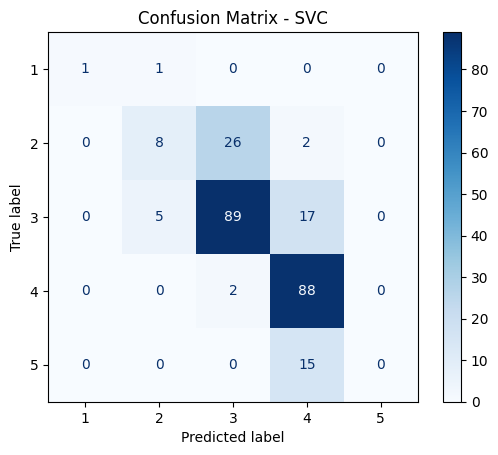


Evaluating LGBM model:
Accuracy: 0.7165
Precision: 0.7209
Recall: 0.7165
F1 Score: 0.6956


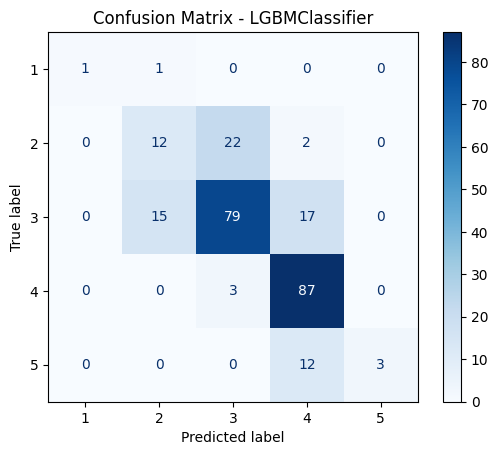

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to print classification metrics and display confusion matrix
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)

    # Precision, Recall, F1-Score
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print the metrics
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix - {model.__class__.__name__}")
    plt.show()

# Evaluate all models
models = [("KNN", knn_tuned),
          ("SVM", svm_tuned),
          ("LGBM", lgbm_tuned)]

for name, model in models:
    print(f"\nEvaluating {name} model:")
    evaluate_model(model, X_test, y_test)


In [31]:
print((X_test))

     Patients number per hour  Saturation  Length of stay_min  \
752                     0.000       0.000              -0.019   
965                    -0.600       0.000               1.177   
678                    -0.300      -0.200              -0.018   
870                    -0.400       0.000               0.027   
954                     0.100       0.000              -0.022   
..                        ...         ...                 ...   
680                    -0.300       0.000              -0.015   
73                      0.200       0.000              -0.014   
424                     0.000      -0.400               0.056   
348                    -0.300       0.000              -0.019   
974                    -0.100       0.000               0.000   

     Group_Regional ED (4th Degree)  Sex_Male  Arrival mode_Private Ambulance  \
752                           False     False                           False   
965                            True      True            

In [32]:
# Predict KTAS_expert for the test dataset
y_test_pred = lgbm_tuned.predict(X_test)

# Display true target and predicted values
results = pd.DataFrame({
    "True KTAS_expert": y_test,
    "Predicted KTAS_expert": y_test_pred
})

# Display the first few rows of results
print(results.head())

# Optional: Evaluate the model accuracy on the test dataset
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")


   True KTAS_expert  Predicted KTAS_expert
0                 3                      3
1                 3                      2
2                 4                      4
3                 2                      3
4                 4                      4
Test Accuracy: 0.72


In [33]:
results.head(100)

,True KTAS_expert,Predicted KTAS_expert
0,3,3
1,3,2
2,4,4
3,2,3
4,4,4
...,...,...
95,3,3
96,4,4
97,4,4
98,3,3


In [34]:
len(results)

254

In [35]:
# Save the model
import joblib
for name, model in models:
    if name == "LGBM":

      joblib.dump(model, f'{name}_model.pkl')

